# Regression Tasks

This notebook addresses the regression tasks for predicting Customer Lifetime Value (CLV_Continuous) using the FinTech dataset. We will build upon the preprocessing from Assignment 01 and apply various regression techniques.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Task 1: Data Preprocessing

Start to clean and preprocess the dataset to ensure it is ready for analysis. 

- Use your knowledge of data preprocessing to thoroughly clean and prepare the dataset for 
training. 
- Note: You can reuse or build upon the data cleaning steps from the classification 
assignment. A single, well-documented preprocessing script or notebook is encouraged.

We reuse and build upon the data cleaning steps from the classification assignment. The preprocessing includes:
- Loading the data
- Handling missing values
- Fixing range violations and logical inconsistencies
- Feature engineering and encoding
- Train-test split

In [2]:
# Load the dataset
FinTech = pd.read_csv("../Hausarbeit/dataset.csv")
print(f"Dataset shape: {FinTech.shape}")
FinTech.head()

Dataset shape: (8662, 22)


,Customer_ID,CCreditScore,CGeography,CGender,CAge,CTenure,CBalance,CNumOfProducts,CHasCrCard,CIsActiveMember,...,Account_Age_Months,Avg_Monthly_Transactions,Transaction_Variance,Last_Login_Days_Ago,Support_Tickets_Count,Mobile_App_Usage_Hours,Onboarding_Month,Is_Holiday_Onboarding,Churn,CLV_Continuous
0,CUST_000001,553.295220,France,Male,39,2,131008.168572,1,1,0,...,36.942433,8,4.959478,1.094710,1,7.979899,8,0,0,21696.256022
1,CUST_000002,552.939394,France,Male,33,4,118529.788812,1,0,0,...,23.748871,11,9.866506,14.809607,0,11.565167,11,0,0,15918.891128
2,CUST_000003,688.745934,Spain,Male,40,1,-879.724555,2,1,1,...,1.114543,13,6.178311,26.434273,0,3.331838,2,0,0,10361.315773
3,CUST_000004,771.940664,France,Male,40,9,125563.132706,1,1,0,...,1.662811,12,4.509500,18.540471,2,12.714742,1,1,0,15189.776245
4,CUST_000005,484.092560,France,Male,55,5,95759.918567,1,0,1,...,24.007725,8,18.786985,11.893918,1,0.719512,2,0,0,14631.814966


In [3]:
# Examine data types and missing values
FinTech.info()
print("\nMissing values:")
print(FinTech.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8662 entries, 0 to 8661
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               8662 non-null   object 
 1   CCreditScore              8662 non-null   float64
 2   CGeography                8662 non-null   object 
 3   CGender                   8662 non-null   object 
 4   CAge                      8662 non-null   int64  
 5   CTenure                   8662 non-null   int64  
 6   CBalance                  8585 non-null   float64
 7   CNumOfProducts            8662 non-null   int64  
 8   CHasCrCard                8662 non-null   int64  
 9   CIsActiveMember           8662 non-null   int64  
 10  CEstimatedSalary          7884 non-null   float64
 11  Days_Since_Onboarding     8662 non-null   float64
 12  Account_Age_Months        8662 non-null   float64
 13  Avg_Monthly_Transactions  8662 non-null   int64  
 14  Transact

In [4]:
# Statistical summary
FinTech.describe()

,CCreditScore,CAge,CTenure,CBalance,CNumOfProducts,CHasCrCard,CIsActiveMember,CEstimatedSalary,Days_Since_Onboarding,Account_Age_Months,Avg_Monthly_Transactions,Transaction_Variance,Last_Login_Days_Ago,Support_Tickets_Count,Mobile_App_Usage_Hours,Onboarding_Month,Is_Holiday_Onboarding,Churn,CLV_Continuous
count,8662.000000,8662.000000,8662.000000,8585.000000,8662.000000,8662.000000,8662.000000,7884.000000,8662.000000,8662.000000,8662.000000,8662.000000,8662.000000,8662.000000,8662.000000,8662.000000,8662.000000,8662.000000,8662.000000
mean,650.540011,38.452205,5.023667,73768.694158,1.536481,0.705842,0.541676,100456.168551,403.245271,13.441509,11.986031,7.921578,16.045260,0.518241,5.002573,6.466059,0.173055,0.074001,13665.885510
std,99.006956,23.230659,2.882572,62813.135006,0.532727,0.455690,0.498289,57500.207029,398.680966,13.289366,3.460255,5.669948,11.473833,0.795047,5.072964,3.465693,0.378316,0.261788,5443.761692
min,0.000000,-1.000000,0.000000,-7218.834421,1.000000,0.000000,0.000000,-3666.109072,0.019016,0.000634,1.000000,0.012763,0.100900,0.000000,0.001294,1.000000,0.000000,0.000000,1428.027822
25%,584.429434,31.000000,3.000000,732.953320,1.000000,0.000000,0.000000,51236.856604,115.675018,3.855834,10.000000,3.692048,7.746004,0.000000,1.434304,3.000000,0.000000,0.000000,9062.956356
50%,652.875073,36.000000,5.000000,93650.834343,2.000000,1.000000,1.000000,100947.390036,278.752013,9.291734,12.000000,6.655946,13.249371,0.000000,3.472211,6.000000,0.000000,0.000000,14016.567785
75%,717.470169,42.000000,7.000000,126845.364452,2.000000,1.000000,1.000000,149353.871919,562.316705,18.743890,14.000000,10.599636,21.511248,1.000000,6.814249,9.000000,0.000000,0.000000,18003.114096
max,857.457755,999.000000,10.000000,220214.292303,4.000000,1.000000,1.000000,204659.480377,3664.777349,122.159245,28.000000,45.260133,110.095776,6.000000,45.200947,12.000000,1.000000,1.000000,29123.502825


### 1.1 Data Cleaning Functions

We define helper functions for handling range violations and logical inconsistencies, as established in the classification assignment.

In [5]:
def handle_range_violations(df, column, min_val, max_val, strategy='impute'):
    """Handle range violations for a single column in the dataframe.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe (will be copied before changes).
    column : str
        Column name to check and fix.
    min_val, max_val : numeric or None
        Bounds for the valid range. Use None for one-sided bounds.
    strategy : {'impute','clip','remove'}
        How to handle invalid values.
    """
    df = df.copy()
    if column not in df.columns:
        return df

    # Build invalid mask depending on which bounds are provided
    if min_val is not None and max_val is not None:
        invalid_mask = (df[column] < min_val) | (df[column] > max_val)
    elif min_val is not None:
        invalid_mask = df[column] < min_val
    elif max_val is not None:
        invalid_mask = df[column] > max_val
    else:
        return df

    n_invalid = int(invalid_mask.sum())
    if n_invalid == 0:
        return df

    print(f"Found {n_invalid} invalid values in '{column}'. Applying strategy '{strategy}'.")

    if strategy == 'impute':
        valid_mask = (~invalid_mask) & df[column].notna()
        if valid_mask.sum() > 0:
            replacement = df.loc[valid_mask, column].median(skipna=True)
        else:
            replacement = df[column].median(skipna=True)
        if not pd.isna(replacement):
            df.loc[invalid_mask, column] = replacement

    return df

In [6]:
# Define valid ranges for columns
valid_ranges = {
    "CCreditScore": (0, None), 
    "CAge": (0, None),   
    'CTenure': (0, None),               
    "CNumOfProducts": (1, 4),
    "CHasCrCard": (0, 1),
    'CIsActiveMember': (0, 1),
    "CEstimatedSalary": (0, None),
    "Days_Since_Onboarding": (0, None),
    "Account_Age_Months": (0, None),
    "Avg_Monthly_Transactions": (0, None),
    "Transaction_Variance": (0, None),
    "Last_Login_Days_Ago": (0, None),
    "Support_Tickets_Count": (0, None),
    "Mobile_App_Usage_Hours": (0, None),
    "Onboarding_Month": (1, 12),
    "Is_Holiday_Onboarding": (0, 1),
    "Churn": (0, 1),
    "CLV_Continuous": (0, None)
}

# Apply range violation handling
FinTech_cleaned = FinTech.copy()
for column, (min_val, max_val) in valid_ranges.items():
    if column in FinTech_cleaned.columns:
        FinTech_cleaned = handle_range_violations(
            FinTech_cleaned, column, min_val, max_val, strategy='impute'
        )

Found 2 invalid values in 'CAge'. Applying strategy 'impute'.
Found 26 invalid values in 'CEstimatedSalary'. Applying strategy 'impute'.


In [7]:
# Fix logical inconsistencies
days_per_month = 30.44

def fix_age_tenure_constraint(df):
    df = df.copy()
    violations = df[df['CAge'] < df['CTenure']].index
    if len(violations) > 0:
        for idx in violations:
            df.loc[idx, 'CTenure'] = min(df.loc[idx, 'CTenure'], df.loc[idx, 'CAge'])
        print(f"Fixed {len(violations)} age-tenure violations")
    return df

def fix_onboarding_account_age_constraint(df, days_per_month, tolerance_months=1):
    df = df.copy()
    expected = df['Days_Since_Onboarding'] / days_per_month
    discrepancy = abs(df['Account_Age_Months'] - expected)
    violations = df[discrepancy > tolerance_months].index
    if len(violations) > 0:
        for idx in violations:
            df.loc[idx, 'Days_Since_Onboarding'] = df.loc[idx, 'Account_Age_Months'] * days_per_month
        print(f"Fixed {len(violations)} onboarding-account age violations")
    return df

def fix_temporal_consistency_constraint(df, days_per_month):
    df = df.copy()
    account_age_days = df['Account_Age_Months'] * days_per_month
    violations = df[df['Last_Login_Days_Ago'] > account_age_days].index
    if len(violations) > 0:
        for idx in violations:
            account_age_in_days = df.loc[idx, 'Account_Age_Months'] * days_per_month
            df.loc[idx, 'Last_Login_Days_Ago'] = max(1, account_age_in_days - 1)
        print(f"Fixed {len(violations)} temporal consistency violations")
    return df

# Apply logical constraint fixes
FinTech_cleaned = fix_age_tenure_constraint(FinTech_cleaned)
FinTech_cleaned = fix_onboarding_account_age_constraint(FinTech_cleaned, days_per_month)
FinTech_cleaned = fix_temporal_consistency_constraint(FinTech_cleaned, days_per_month)

Fixed 40 onboarding-account age violations
Fixed 322 temporal consistency violations


### 1.2 Feature Preparation for Regression

For the regression task, we prepare features by:
- Dropping the Customer_ID (identifier, not predictive)
- Dropping Days_Since_Onboarding (redundant with Account_Age_Months)
- Dropping Churn (target for classification, not used in regression)
- Handling missing values
- Encoding categorical variables
- Scaling numerical features

In [8]:
# Prepare features for regression
# Drop identifier, redundant features, and classification target
columns_to_drop = ['Customer_ID', 'Days_Since_Onboarding', 'Churn']
FinTech_reg = FinTech_cleaned.drop(columns=columns_to_drop, errors='ignore')

print(f"Features after dropping columns: {FinTech_reg.shape}")
print(f"\nRemaining columns: {list(FinTech_reg.columns)}")

Features after dropping columns: (8662, 19)

Remaining columns: ['CCreditScore', 'CGeography', 'CGender', 'CAge', 'CTenure', 'CBalance', 'CNumOfProducts', 'CHasCrCard', 'CIsActiveMember', 'CEstimatedSalary', 'Account_Age_Months', 'Avg_Monthly_Transactions', 'Transaction_Variance', 'Last_Login_Days_Ago', 'Support_Tickets_Count', 'Mobile_App_Usage_Hours', 'Onboarding_Month', 'Is_Holiday_Onboarding', 'CLV_Continuous']


In [9]:
# Define target and features
target = 'CLV_Continuous'
y = FinTech_reg[target]
X = FinTech_reg.drop(columns=[target])

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['CGeography', 'CGender']
Numerical columns: ['CCreditScore', 'CAge', 'CTenure', 'CBalance', 'CNumOfProducts', 'CHasCrCard', 'CIsActiveMember', 'CEstimatedSalary', 'Account_Age_Months', 'Avg_Monthly_Transactions', 'Transaction_Variance', 'Last_Login_Days_Ago', 'Support_Tickets_Count', 'Mobile_App_Usage_Hours', 'Onboarding_Month', 'Is_Holiday_Onboarding']


In [10]:
# Handle missing values - impute with median for numerical, mode for categorical
from sklearn.impute import SimpleImputer

# Impute numerical columns
num_imputer = SimpleImputer(strategy='median')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

# Verify no missing values remain in numerical columns
print(f"Missing values after imputation:")
print(X.isnull().sum())

Missing values after imputation:
CCreditScore                0
CGeography                  0
CGender                     0
CAge                        0
CTenure                     0
CBalance                    0
CNumOfProducts              0
CHasCrCard                  0
CIsActiveMember             0
CEstimatedSalary            0
Account_Age_Months          0
Avg_Monthly_Transactions    0
Transaction_Variance        0
Last_Login_Days_Ago         0
Support_Tickets_Count       0
Mobile_App_Usage_Hours      0
Onboarding_Month            0
Is_Holiday_Onboarding       0
dtype: int64


In [11]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 6929
Test set size: 1733


In [12]:
# Create preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Fit preprocessor on training data and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")

Processed training shape: (6929, 27)
Processed test shape: (1733, 27)


In [13]:
# Get feature names after preprocessing
num_feature_names = numerical_cols
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
all_feature_names = num_feature_names + cat_feature_names
print(f"Total features after preprocessing: {len(all_feature_names)}")

Total features after preprocessing: 27


### 1.3 Target Variable Analysis

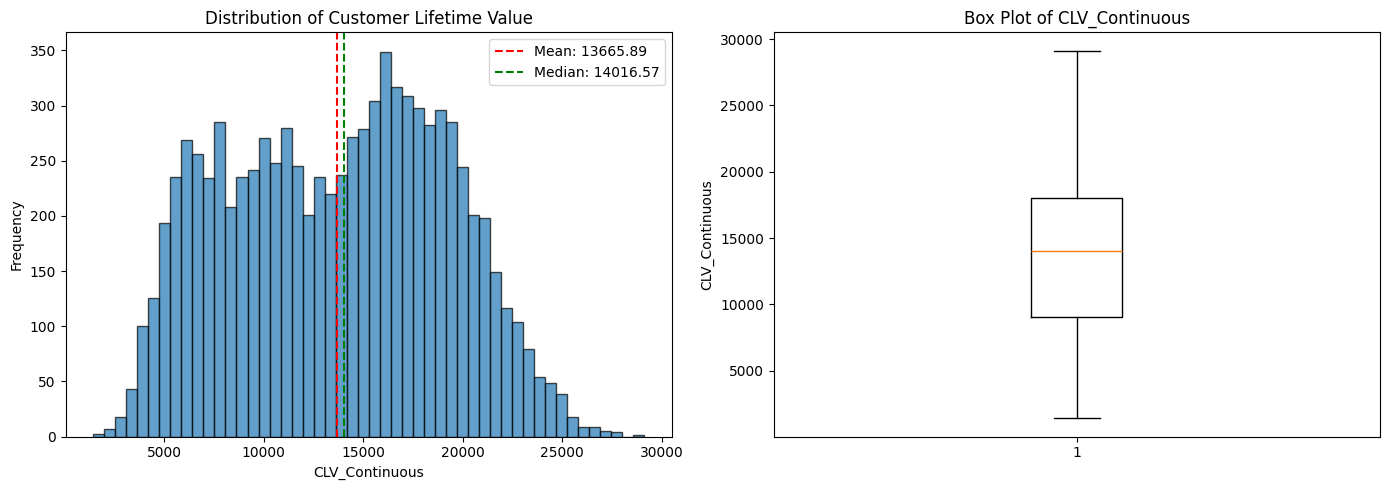

Target variable statistics:
count     8662.000000
mean     13665.885510
std       5443.761692
min       1428.027822
25%       9062.956356
50%      14016.567785
75%      18003.114096
max      29123.502825
Name: CLV_Continuous, dtype: float64


In [14]:
# Analyze the target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('CLV_Continuous')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Customer Lifetime Value')
axes[0].axvline(y.mean(), color='red', linestyle='--', label=f'Mean: {y.mean():.2f}')
axes[0].axvline(y.median(), color='green', linestyle='--', label=f'Median: {y.median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(y, vert=True)
axes[1].set_ylabel('CLV_Continuous')
axes[1].set_title('Box Plot of CLV_Continuous')

plt.tight_layout()
plt.show()

print(f"Target variable statistics:")
print(y.describe())

## Task 2: Train and Evaluate Multiple Regression Model

- Build a multiple linear regression model to predict Customer Lifetime Value (regression using 
the 'CLV_Continuous' target variable)". 
- Describe your approach to building the model and interpret the performance based on 
appropriate evaluation metrics. 

Note: You are not expected to use regularization or hyperparameter tuning at this stage. 

We build a multiple linear regression model to predict Customer Lifetime Value. Linear regression assumes a linear relationship between features and the target, and provides interpretable coefficients.

In [15]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """Evaluate regression model and return metrics."""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred)
    }
    
    print(f"\n{'='*60}")
    print(f"{model_name} Performance")
    print(f"{'='*60}")
    print(f"\nTraining Set:")
    print(f"  R-squared: {metrics['Train_R2']:.4f}")
    print(f"  RMSE: {metrics['Train_RMSE']:.2f}")
    print(f"  MAE: {metrics['Train_MAE']:.2f}")
    print(f"\nTest Set:")
    print(f"  R-squared: {metrics['Test_R2']:.4f}")
    print(f"  RMSE: {metrics['Test_RMSE']:.2f}")
    print(f"  MAE: {metrics['Test_MAE']:.2f}")
    
    # Check for overfitting
    r2_diff = metrics['Train_R2'] - metrics['Test_R2']
    if r2_diff > 0.1:
        print(f"\n[WARNING] Possible overfitting detected (Train-Test R2 gap: {r2_diff:.4f})")
    elif metrics['Test_R2'] < 0.3:
        print(f"\n[WARNING] Possible underfitting detected (Test R2: {metrics['Test_R2']:.4f})")
    else:
        print(f"\n[OK] Model appears well-fitted (Train-Test R2 gap: {r2_diff:.4f})")
    
    return metrics, y_test_pred

In [16]:
# Train Multiple Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)

# Evaluate the model
lr_metrics, lr_pred = evaluate_model(
    lr_model, X_train_processed, X_test_processed, 
    y_train, y_test, "Multiple Linear Regression"
)


Multiple Linear Regression Performance

Training Set:
  R-squared: 0.9708
  RMSE: 933.12
  MAE: 474.52

Test Set:
  R-squared: 0.9698
  RMSE: 934.63
  MAE: 457.80

[OK] Model appears well-fitted (Train-Test R2 gap: 0.0010)


Top 10 Most Important Features (by absolute coefficient):


               Feature  Coefficient
3             CBalance  5001.148939
7     CEstimatedSalary  2183.908483
21    CGeography_SPAIN  -674.250223
8   Account_Age_Months   657.818998
4       CNumOfProducts   647.488506
6      CIsActiveMember   610.132722
5           CHasCrCard   368.762974
22    CGeography_Spain  -276.812306
17       CGeography_Fr  -260.324169
20  CGeography_Germany  -253.121841


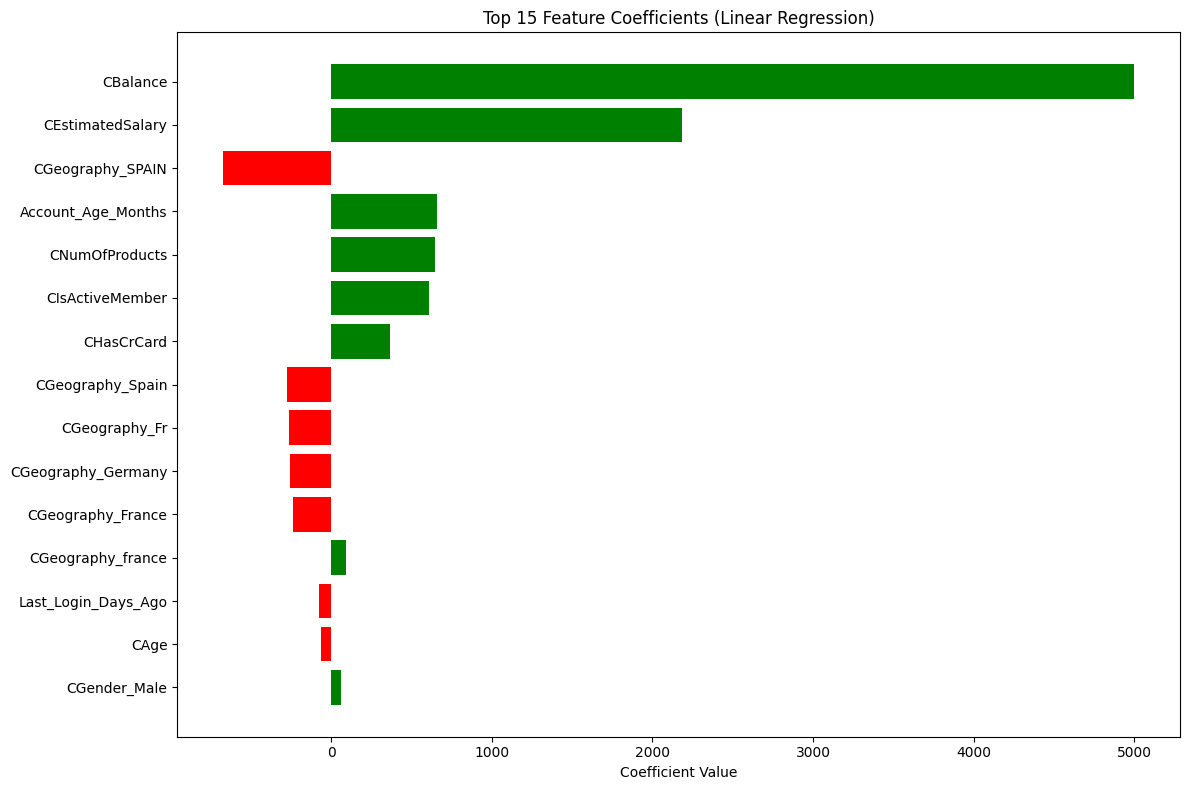

In [17]:
# Analyze coefficients
coefficients = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Top 10 Most Important Features (by absolute coefficient):")
print(coefficients.head(10))

# Visualize top coefficients
plt.figure(figsize=(12, 8))
top_n = 15
top_coefs = coefficients.head(top_n)
colors = ['green' if c > 0 else 'red' for c in top_coefs['Coefficient']]
plt.barh(range(top_n), top_coefs['Coefficient'], color=colors)
plt.yticks(range(top_n), top_coefs['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients (Linear Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

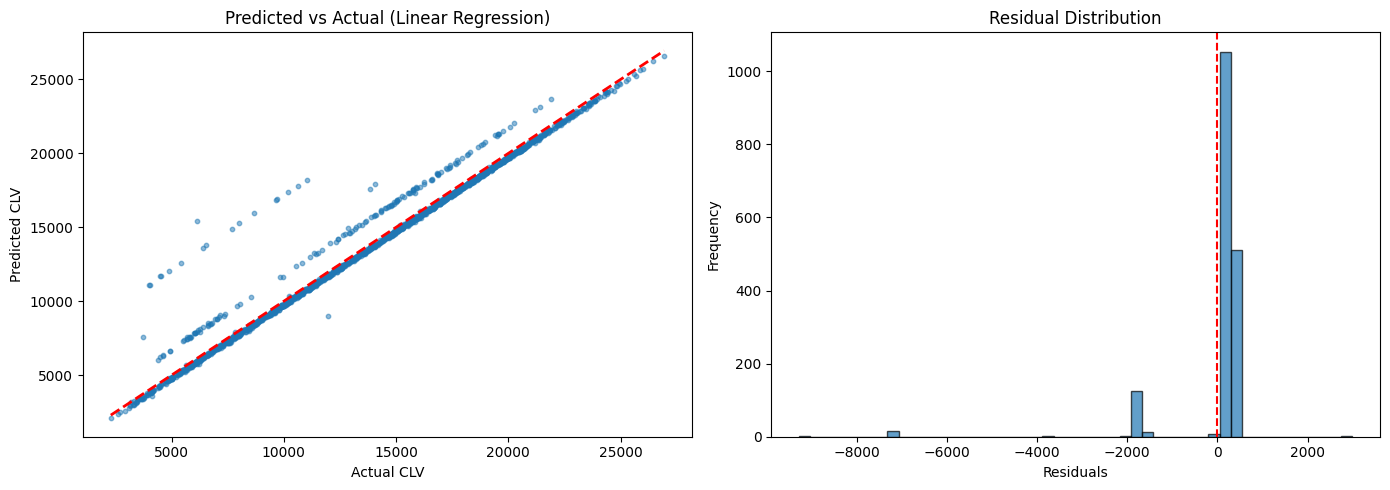

In [18]:
# Residual analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals = y_test - lr_pred

# Predicted vs Actual
axes[0].scatter(y_test, lr_pred, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual CLV')
axes[0].set_ylabel('Predicted CLV')
axes[0].set_title('Predicted vs Actual (Linear Regression)')

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

### Interpretation of Linear Regression Results

The multiple linear regression model provides a baseline for predicting Customer Lifetime Value. Key observations:

1. **R-squared**: Indicates the proportion of variance in CLV explained by the model
2. **RMSE**: Root Mean Squared Error in the same units as CLV (dollars)
3. **MAE**: Mean Absolute Error, representing average prediction error
4. **Coefficients**: Show the direction and magnitude of each feature's impact on CLV

The residual plot helps identify whether the linear model captures the underlying relationship well.

## Task 3: Polynomial Regression Models

• Train and evaluate at least two polynomial regression models with different polynomial 
degrees. 
• Compare the results of the polynomial regression models with the linear regression model 
from Task 2. Discuss how the model's performance changes as the degree of the polynomial 
increases.

Polynomial regression extends linear regression by adding polynomial terms, allowing the model to capture non-linear relationships. (relationships between features) We will train models with different polynomial degrees and compare their performance.

TODO: put poly regression in pipeline to display learning curves

In [19]:
# Train polynomial regression models with different degrees
poly_results = []

for degree in [2, 3]:
    print(f"\n{'='*60}")
    print(f"Training Polynomial Regression (degree={degree})")
    print(f"{'='*60}")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_processed)
    X_test_poly = poly.transform(X_test_processed)
    
    print(f"Features after polynomial transformation: {X_train_poly.shape[1]}")
    
    # Train model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    
    # Evaluate
    metrics, pred = evaluate_model(
        poly_model, X_train_poly, X_test_poly,
        y_train, y_test, f"Polynomial Regression (degree={degree})"
    )
    
    poly_results.append({
        'degree': degree,
        'model': poly_model,
        'poly_transformer': poly,
        'metrics': metrics,
        'predictions': pred
    })
    #TODO: MSE?


Training Polynomial Regression (degree=2)
Features after polynomial transformation: 405

Polynomial Regression (degree=2) Performance

Training Set:
  R-squared: 0.9738
  RMSE: 884.70
  MAE: 478.54

Test Set:
  R-squared: 0.9656
  RMSE: 996.87
  MAE: 499.99

[OK] Model appears well-fitted (Train-Test R2 gap: 0.0082)

Training Polynomial Regression (degree=3)
Features after polynomial transformation: 4059

Polynomial Regression (degree=3) Performance

Training Set:
  R-squared: 0.9794
  RMSE: 783.06
  MAE: 475.12

Test Set:
  R-squared: -6.0167
  RMSE: 14235.77
  MAE: 955.14

[WARNING] Possible overfitting detected (Train-Test R2 gap: 6.9962)


In [20]:
# Compare polynomial models
comparison_data = [lr_metrics] + [r['metrics'] for r in poly_results]
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df[['Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE']]

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
                           Model  Train_R2   Test_R2  Train_RMSE    Test_RMSE  Train_MAE   Test_MAE
      Multiple Linear Regression  0.970799  0.969755  933.123576   934.629523 474.516305 457.803138
Polynomial Regression (degree=2)  0.973751  0.965592  884.695923   996.874344 478.538026 499.989849
Polynomial Regression (degree=3)  0.979436 -6.016728  783.056400 14235.771116 475.117643 955.141131


#TODO: learning curves

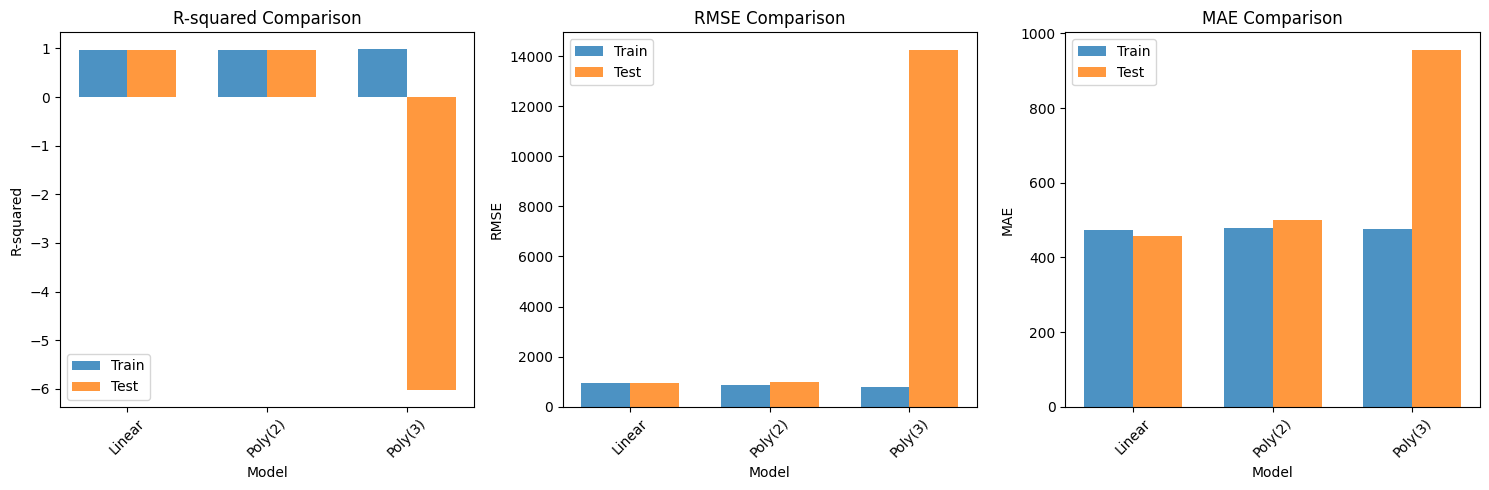

In [21]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = comparison_df['Model'].tolist()
x_pos = range(len(models))

# R2 comparison
axes[0].bar(x_pos, comparison_df['Train_R2'], width=0.35, label='Train', alpha=0.8)
axes[0].bar([p + 0.35 for p in x_pos], comparison_df['Test_R2'], width=0.35, label='Test', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R-squared')
axes[0].set_title('R-squared Comparison')
axes[0].set_xticks([p + 0.175 for p in x_pos])
axes[0].set_xticklabels(['Linear', 'Poly(2)', 'Poly(3)'], rotation=45)
axes[0].legend()

# RMSE comparison
axes[1].bar(x_pos, comparison_df['Train_RMSE'], width=0.35, label='Train', alpha=0.8)
axes[1].bar([p + 0.35 for p in x_pos], comparison_df['Test_RMSE'], width=0.35, label='Test', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison')
axes[1].set_xticks([p + 0.175 for p in x_pos])
axes[1].set_xticklabels(['Linear', 'Poly(2)', 'Poly(3)'], rotation=45)
axes[1].legend()

# MAE comparison
axes[2].bar(x_pos, comparison_df['Train_MAE'], width=0.35, label='Train', alpha=0.8)
axes[2].bar([p + 0.35 for p in x_pos], comparison_df['Test_MAE'], width=0.35, label='Test', alpha=0.8)
axes[2].set_xlabel('Model')
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE Comparison')
axes[2].set_xticks([p + 0.175 for p in x_pos])
axes[2].set_xticklabels(['Linear', 'Poly(2)', 'Poly(3)'], rotation=45)
axes[2].legend()

plt.tight_layout()
plt.show()

### Discussion: Polynomial Regression Performance

As the polynomial degree increases:
- **Training performance** typically improves (higher R2, lower RMSE/MAE)
- **Test performance** may improve initially but can degrade with higher degrees
- A large gap between train and test performance indicates **overfitting**

Higher-degree polynomials create more complex models that can memorize training data but fail to generalize to new data.
Risk of severly overfitting.

## Task 4: Model Comparison

- Compare the performance of the multiple linear regression model from Task 2 and the 
polynomial regression models from Task 3. 
- Discuss which model performs better and provide a rationale for your conclusions. 
Note: Regularization and hyperparameter tuning are not required at this point. 

We compare the linear and polynomial regression models to determine which performs best.

In [22]:
# Comprehensive comparison
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Find best model based on test R2
best_idx = comparison_df['Test_R2'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_test_r2 = comparison_df.loc[best_idx, 'Test_R2']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test R-squared: {best_test_r2:.4f}")
print(f"{'='*80}")


MODEL COMPARISON SUMMARY
                           Model  Train_R2   Test_R2  Train_RMSE    Test_RMSE  Train_MAE   Test_MAE
      Multiple Linear Regression  0.970799  0.969755  933.123576   934.629523 474.516305 457.803138
Polynomial Regression (degree=2)  0.973751  0.965592  884.695923   996.874344 478.538026 499.989849
Polynomial Regression (degree=3)  0.979436 -6.016728  783.056400 14235.771116 475.117643 955.141131

BEST MODEL: Multiple Linear Regression
Test R-squared: 0.9698


In [23]:
#TODO: MAE; MSE; RMSE

In [24]:
# Analysis of overfitting
print("\nOverfitting Analysis:")
print("-" * 60)
for idx, row in comparison_df.iterrows():
    train_test_gap = row['Train_R2'] - row['Test_R2']
    status = "OVERFITTING" if train_test_gap > 0.1 else "OK"
    print(f"{row['Model']}: Train-Test R2 Gap = {train_test_gap:.4f} [{status}]")


Overfitting Analysis:
------------------------------------------------------------
Multiple Linear Regression: Train-Test R2 Gap = 0.0010 [OK]
Polynomial Regression (degree=2): Train-Test R2 Gap = 0.0082 [OK]
Polynomial Regression (degree=3): Train-Test R2 Gap = 6.9962 [OVERFITTING]


### Task 4 Conclusion

Based on the comparison:
- **Linear Regression** provides a good baseline with interpretable results
- **Polynomial Regression (degree=2)** may capture some non-linear patterns
- **Polynomial Regression (degree=3)** risks overfitting due to the explosion in features

The best model for further optimization is selected based on the balance between training and test performance.

## Task 5: Regularization and Optimization

- Optimize your results by applying regularization techniques, such as Ridge or Lasso 
regression (Note: select the best-performing model in Task 4). 
- Use cross-validation and hyperparameter tuning (e.g., GridSearchCV or 
RandomizedSearchCV) to further optimize your model's performance. 
- Explain whether your model is overfitting or underfitting, and interpret the results using 
evaluation metrics and visualizations.

We apply regularization techniques (Ridge and Lasso) to optimize the best-performing model from Task 4. Regularization helps prevent overfitting by penalizing large coefficients.

- **Ridge (L2)**: Shrinks coefficients but keeps all features
- **Lasso (L1)**: Can shrink coefficients to zero, performing feature selection

#TODO: Explain overfitting with learning curves. Folie 69
#TODO: Scale Data before ridge regression 

In [25]:
# Ridge Regression with GridSearchCV
print("\n" + "="*60)
print("Ridge Regression with Cross-Validation")
print("="*60)

ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

ridge_grid = GridSearchCV(
    Ridge(),
    ridge_params,
    cv=5,
    scoring='r2',
    return_train_score=True
)

ridge_grid.fit(X_train_processed, y_train)

print(f"Best alpha: {ridge_grid.best_params_['alpha']}")
print(f"Best CV R2: {ridge_grid.best_score_:.4f}")

# Evaluate best Ridge model
ridge_metrics, ridge_pred = evaluate_model(
    ridge_grid.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, f"Ridge Regression (alpha={ridge_grid.best_params_['alpha']})"
)


Ridge Regression with Cross-Validation
Best alpha: 10
Best CV R2: 0.9690

Ridge Regression (alpha=10) Performance

Training Set:
  R-squared: 0.9708
  RMSE: 933.25
  MAE: 474.47

Test Set:
  R-squared: 0.9698
  RMSE: 934.58
  MAE: 457.28

[OK] Model appears well-fitted (Train-Test R2 gap: 0.0010)


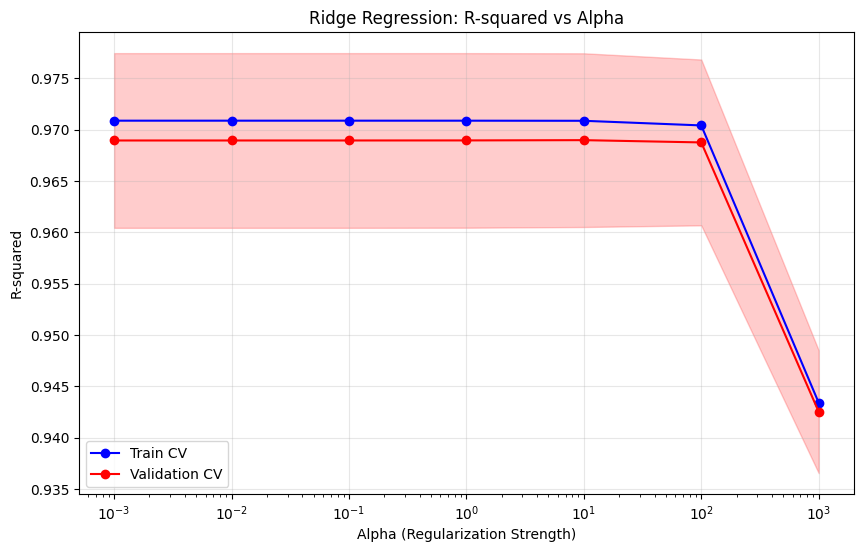

In [26]:
# Visualize Ridge CV results
ridge_cv_results = pd.DataFrame(ridge_grid.cv_results_)

plt.figure(figsize=(10, 6))
plt.semilogx(ridge_params['alpha'], ridge_cv_results['mean_train_score'], 'b-o', label='Train CV')
plt.semilogx(ridge_params['alpha'], ridge_cv_results['mean_test_score'], 'r-o', label='Validation CV')
plt.fill_between(ridge_params['alpha'], 
                 ridge_cv_results['mean_test_score'] - ridge_cv_results['std_test_score'],
                 ridge_cv_results['mean_test_score'] + ridge_cv_results['std_test_score'],
                 alpha=0.2, color='red')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('R-squared')
plt.title('Ridge Regression: R-squared vs Alpha')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Ridge OR Lasso

In [27]:
# Lasso Regression with GridSearchCV
print("\n" + "="*60)
print("Lasso Regression with Cross-Validation")
print("="*60)

lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

lasso_grid = GridSearchCV(
    Lasso(max_iter=10000),
    lasso_params,
    cv=5,
    scoring='r2',
    return_train_score=True
)

lasso_grid.fit(X_train_processed, y_train)

print(f"Best alpha: {lasso_grid.best_params_['alpha']}")
print(f"Best CV R2: {lasso_grid.best_score_:.4f}")

# Evaluate best Lasso model
lasso_metrics, lasso_pred = evaluate_model(
    lasso_grid.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, f"Lasso Regression (alpha={lasso_grid.best_params_['alpha']})"
)


Lasso Regression with Cross-Validation
Best alpha: 10
Best CV R2: 0.9695

Lasso Regression (alpha=10) Performance

Training Set:
  R-squared: 0.9707
  RMSE: 934.42
  MAE: 475.64

Test Set:
  R-squared: 0.9698
  RMSE: 934.57
  MAE: 458.58

[OK] Model appears well-fitted (Train-Test R2 gap: 0.0010)


In [28]:
# Lasso feature selection analysis
lasso_coefs = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': lasso_grid.best_estimator_.coef_
})

n_selected = (lasso_coefs['Coefficient'] != 0).sum()
n_eliminated = (lasso_coefs['Coefficient'] == 0).sum()

print(f"\nLasso Feature Selection:")
print(f"  Features selected: {n_selected}")
print(f"  Features eliminated: {n_eliminated}")

# Show non-zero coefficients
selected_features = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)
print(f"\nSelected Features (non-zero coefficients):")
print(selected_features.to_string(index=False))


Lasso Feature Selection:
  Features selected: 13
  Features eliminated: 14

Selected Features (non-zero coefficients):
               Feature  Coefficient
              CBalance  4984.812610
      CEstimatedSalary  2174.078413
    Account_Age_Months   647.289832
        CNumOfProducts   630.671105
       CIsActiveMember   598.656958
            CHasCrCard   358.653516
   Last_Login_Days_Ago   -66.219365
                  CAge   -54.730624
          CGender_Male    22.611253
 Is_Holiday_Onboarding     3.559645
Mobile_App_Usage_Hours     3.483284
 Support_Tickets_Count    -0.326642
  Transaction_Variance     0.013964


In [29]:
# Compare regularized models with baseline
regularized_comparison = pd.DataFrame([
    lr_metrics,
    ridge_metrics,
    lasso_metrics
])

print("\n" + "="*80)
print("REGULARIZATION COMPARISON")
print("="*80)
print(regularized_comparison[['Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE']].to_string(index=False))


REGULARIZATION COMPARISON
                      Model  Train_R2  Test_R2  Train_RMSE  Test_RMSE
 Multiple Linear Regression  0.970799 0.969755  933.123576 934.629523
Ridge Regression (alpha=10)  0.970791 0.969758  933.248696 934.581984
Lasso Regression (alpha=10)  0.970718 0.969759  934.420187 934.570852


### Task 5 Analysis

**Regularization Impact:**
- **Ridge Regression**: Penalizes large coefficients (L2 penalty), keeping all features but shrinking their impact
- **Lasso Regression**: Can eliminate features entirely (L1 penalty), performing automatic feature selection

**Cross-Validation**: Ensures our model generalizes well by training and validating on different data subsets.

The optimal regularization strength (alpha) balances between underfitting (too much regularization) and overfitting (too little regularization).

## Task 6: Regression Tree Model

- Train and evaluate a regression tree model to predict Customer Lifetime Value (regression 
using the 'CLV_Continuous' target variable). 
-use hyperparameter tuning and cross-validation to optimize the regression tree model. 
- Analyze and explain whether your model is overfitting or underfitting, and interpret the 
results with appropriate metrics and plots.


Decision Tree Regressors can capture non-linear relationships and feature interactions without explicit polynomial terms. We train and optimize a regression tree using cross-validation and hyperparameter tuning.

In [30]:
# Decision Tree Regressor with GridSearchCV
print("\n" + "="*60)
print("Decision Tree Regressor with Cross-Validation")
print("="*60)

tree_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

tree_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    tree_params,
    cv=5,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1
)

tree_grid.fit(X_train_processed, y_train)

print(f"Best parameters: {tree_grid.best_params_}")
print(f"Best CV R2: {tree_grid.best_score_:.4f}")


Decision Tree Regressor with Cross-Validation
Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 20}
Best CV R2: 0.9682


In [31]:
# Evaluate best tree model
tree_metrics, tree_pred = evaluate_model(
    tree_grid.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, "Decision Tree Regressor (Optimized)"
)


Decision Tree Regressor (Optimized) Performance

Training Set:
  R-squared: 0.9884
  RMSE: 587.40
  MAE: 421.99

Test Set:
  R-squared: 0.9691
  RMSE: 944.75
  MAE: 650.09

[OK] Model appears well-fitted (Train-Test R2 gap: 0.0193)



Top 10 Most Important Features (Decision Tree):
               Feature  Importance
              CBalance    0.795999
      CEstimatedSalary    0.167338
    Account_Age_Months    0.013817
       CIsActiveMember    0.009599
        CNumOfProducts    0.009481
            CHasCrCard    0.002475
   Last_Login_Days_Ago    0.000301
          CCreditScore    0.000222
  Transaction_Variance    0.000196
Mobile_App_Usage_Hours    0.000150


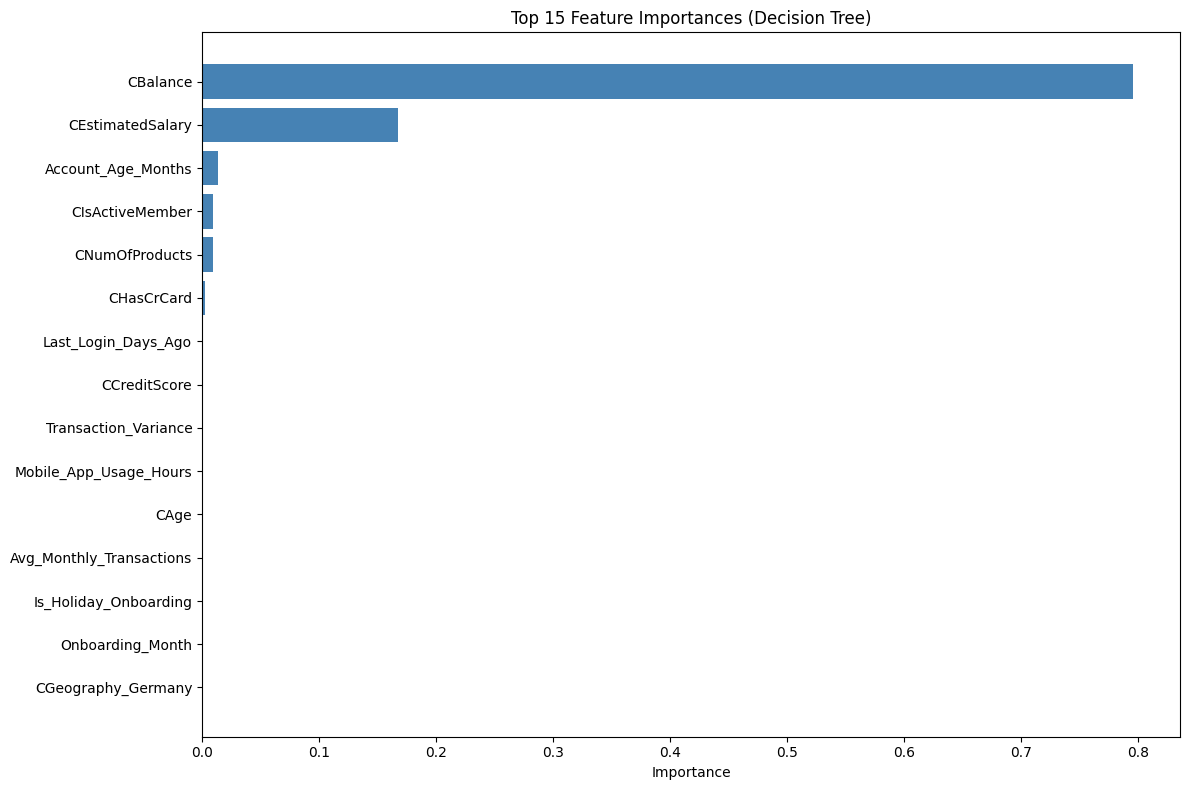

In [32]:
# Feature importance from tree
tree_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': tree_grid.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (Decision Tree):")
print(tree_importance.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_importance = tree_importance.head(15)
plt.barh(range(len(top_importance)), top_importance['Importance'], color='steelblue')
plt.yticks(range(len(top_importance)), top_importance['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Decision Tree)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Decision Tree Analysis:
  Tree depth: 15
  Number of leaves: 607


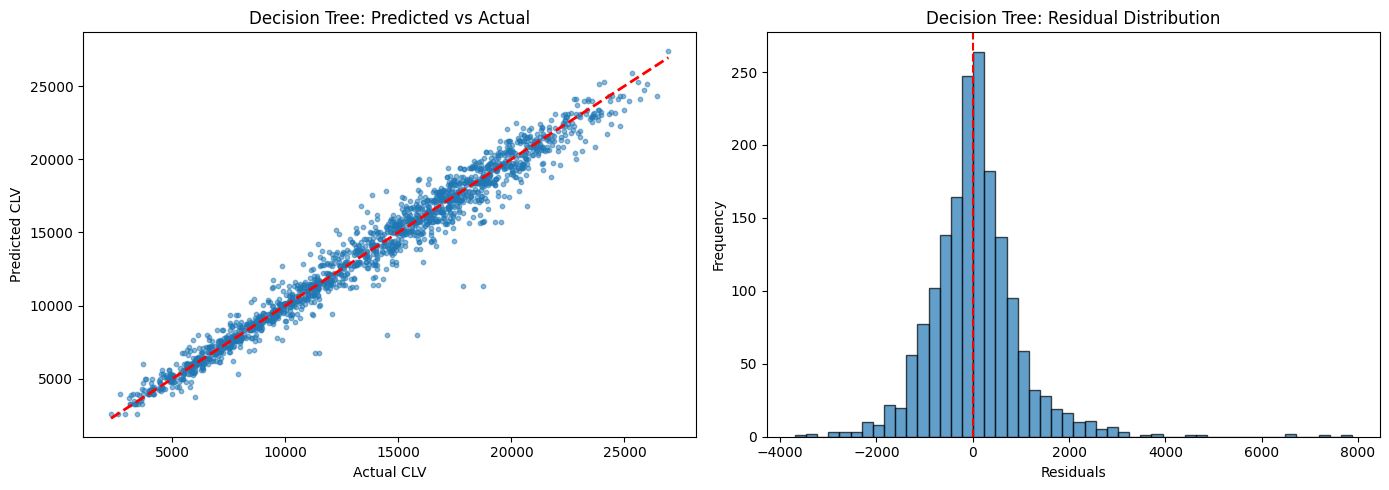

In [33]:
# Analyze tree depth and overfitting
print("\nDecision Tree Analysis:")
print(f"  Tree depth: {tree_grid.best_estimator_.get_depth()}")
print(f"  Number of leaves: {tree_grid.best_estimator_.get_n_leaves()}")

# Visualize predicted vs actual for tree
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, tree_pred, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual CLV')
axes[0].set_ylabel('Predicted CLV')
axes[0].set_title('Decision Tree: Predicted vs Actual')

# Residuals
tree_residuals = y_test - tree_pred
axes[1].hist(tree_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Decision Tree: Residual Distribution')

plt.tight_layout()
plt.show()

### Task 6 Analysis

**Decision Tree Regressor:**
- Captures non-linear relationships through recursive partitioning
- Provides interpretable feature importance
- Hyperparameters (max_depth, min_samples_split, min_samples_leaf) control model complexity

**Overfitting/Underfitting:**
- Deep trees (high max_depth) can overfit
- Shallow trees (low max_depth) may underfit
- The optimal parameters balance these trade-offs

## Task 7: Model Comparison

- Compare the performance of the machine learning model optimized in Task 5 and the 
regression tree model from Task 6. 
- Discuss which model performs better. Also explain why the model performs better. Use 
metrics and reasoning based on the strengths and weaknesses of each model. 

We compare the optimized regularized model from Task 5 with the regression tree from Task 6.

In [34]:
# Comprehensive model comparison
all_models_comparison = pd.DataFrame([
    lr_metrics,
    ridge_metrics,
    lasso_metrics,
    tree_metrics
])

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(all_models_comparison[['Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE']].to_string(index=False))


COMPREHENSIVE MODEL COMPARISON
                              Model  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE   Test_MAE
         Multiple Linear Regression  0.970799 0.969755  933.123576 934.629523 474.516305 457.803138
        Ridge Regression (alpha=10)  0.970791 0.969758  933.248696 934.581984 474.467561 457.276098
        Lasso Regression (alpha=10)  0.970718 0.969759  934.420187 934.570852 475.639029 458.579201
Decision Tree Regressor (Optimized)  0.988428 0.969096  587.404019 944.752861 421.990015 650.089083


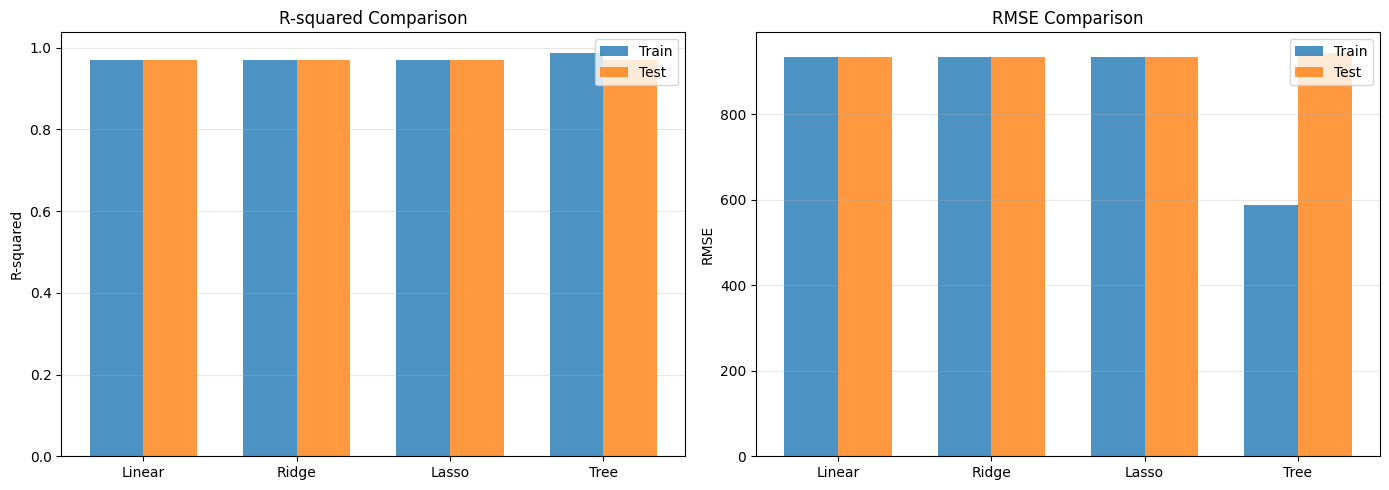

In [35]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['Linear', 'Ridge', 'Lasso', 'Tree']
x = np.arange(len(models))
width = 0.35

# R2 comparison
axes[0].bar(x - width/2, all_models_comparison['Train_R2'], width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, all_models_comparison['Test_R2'], width, label='Test', alpha=0.8)
axes[0].set_ylabel('R-squared')
axes[0].set_title('R-squared Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(x - width/2, all_models_comparison['Train_RMSE'], width, label='Train', alpha=0.8)
axes[1].bar(x + width/2, all_models_comparison['Test_RMSE'], width, label='Test', alpha=0.8)
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
# Determine best model for Task 7
best_task7_idx = all_models_comparison['Test_R2'].idxmax()
best_task7_model = all_models_comparison.loc[best_task7_idx]

print("\n" + "="*80)
print("TASK 7 CONCLUSION: BEST MODEL SELECTION")
print("="*80)
print(f"\nBest Performing Model: {best_task7_model['Model']}")
print(f"  Test R-squared: {best_task7_model['Test_R2']:.4f}")
print(f"  Test RMSE: {best_task7_model['Test_RMSE']:.2f}")
print(f"  Test MAE: {best_task7_model['Test_MAE']:.2f}")

print("\nModel Strengths and Weaknesses:")
print("-" * 60)
print("Linear Models (Ridge/Lasso):")
print("  + Interpretable coefficients")
print("  + Fast training and prediction")
print("  + Regularization prevents overfitting")
print("  - Assumes linear relationships")
print("\nDecision Tree:")
print("  + Captures non-linear relationships")
print("  + No feature scaling required")
print("  + Provides feature importance")
print("  - Can overfit without proper pruning")
print("  - Less stable (high variance)")


TASK 7 CONCLUSION: BEST MODEL SELECTION

Best Performing Model: Lasso Regression (alpha=10)
  Test R-squared: 0.9698
  Test RMSE: 934.57
  Test MAE: 458.58

Model Strengths and Weaknesses:
------------------------------------------------------------
Linear Models (Ridge/Lasso):
  + Interpretable coefficients
  + Fast training and prediction
  + Regularization prevents overfitting
  - Assumes linear relationships

Decision Tree:
  + Captures non-linear relationships
  + No feature scaling required
  + Provides feature importance
  - Can overfit without proper pruning
  - Less stable (high variance)


## Task 8: Ensemble Learning

- Use an ensemble learning technique to improve your model's performance. Compare the 
results with the model you selected from Task 7. 
- Use hyperparameter tuning and cross-validation to optimize your ensemble model. 
- Analyze whether your ensemble model is overfitting or underfitting, and explain the results 
based on your evaluation. 

Ensemble methods combine multiple models to achieve better performance. We will use:
- **Random Forest**: Combines multiple decision trees (bagging)
- **Gradient Boosting**: Sequentially builds trees to correct errors (boosting)

In [37]:
# Random Forest Regressor
print("\n" + "="*60)
print("Random Forest Regressor with Cross-Validation")
print("="*60)

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV for faster search
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    rf_params,
    n_iter=30,
    cv=5,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf_search.fit(X_train_processed, y_train)

print(f"Best parameters: {rf_search.best_params_}")
print(f"Best CV R2: {rf_search.best_score_:.4f}")


Random Forest Regressor with Cross-Validation
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best CV R2: 0.9846


In [38]:
# Evaluate Random Forest
rf_metrics, rf_pred = evaluate_model(
    rf_search.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, "Random Forest (Optimized)"
)


Random Forest (Optimized) Performance

Training Set:
  R-squared: 0.9971
  RMSE: 292.42
  MAE: 191.27

Test Set:
  R-squared: 0.9835
  RMSE: 690.21
  MAE: 440.61

[OK] Model appears well-fitted (Train-Test R2 gap: 0.0136)


In [39]:
# Gradient Boosting Regressor
print("\n" + "="*60)
print("Gradient Boosting Regressor with Cross-Validation")
print("="*60)

gb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    gb_params,
    n_iter=30,
    cv=5,
    scoring='r2',
    return_train_score=True,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gb_search.fit(X_train_processed, y_train)

print(f"Best parameters: {gb_search.best_params_}")
print(f"Best CV R2: {gb_search.best_score_:.4f}")


Gradient Boosting Regressor with Cross-Validation
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.2}
Best CV R2: 0.9969


In [40]:
# Evaluate Gradient Boosting
gb_metrics, gb_pred = evaluate_model(
    gb_search.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test, "Gradient Boosting (Optimized)"
)


Gradient Boosting (Optimized) Performance

Training Set:
  R-squared: 0.9986
  RMSE: 205.56
  MAE: 144.49

Test Set:
  R-squared: 0.9936
  RMSE: 428.99
  MAE: 200.24

[OK] Model appears well-fitted (Train-Test R2 gap: 0.0050)


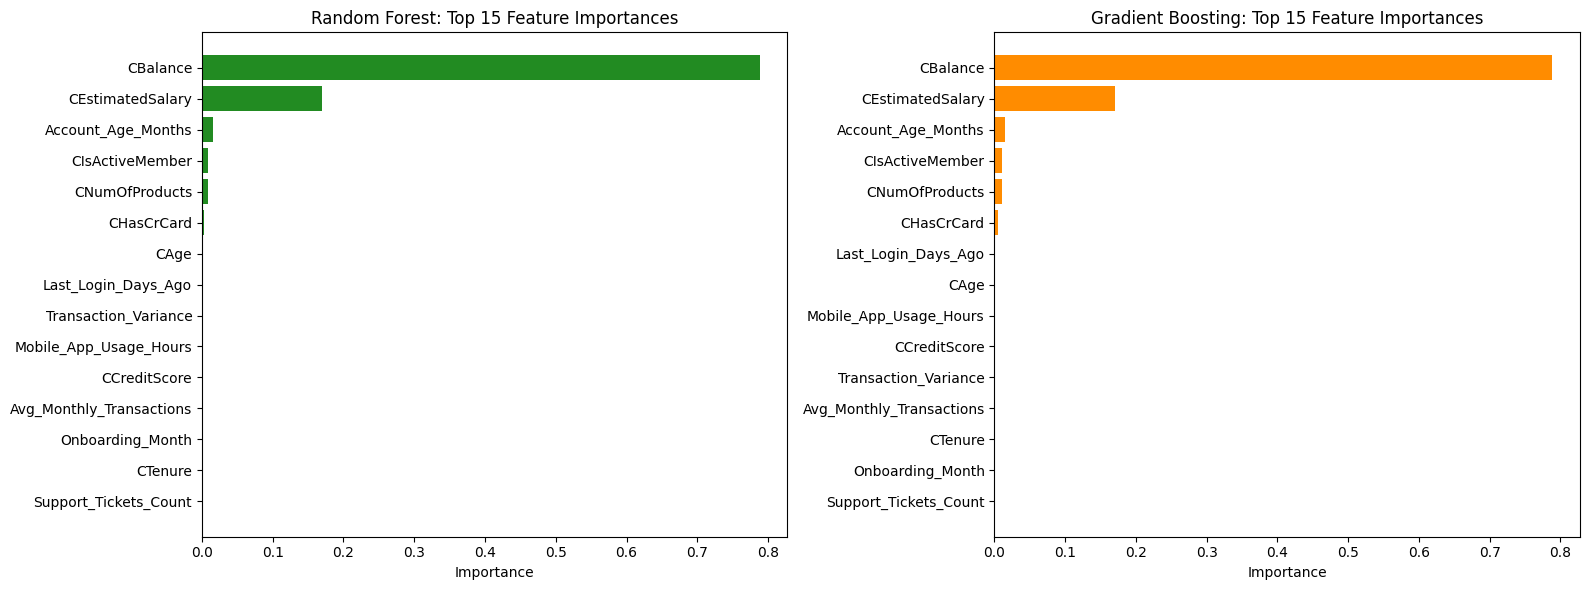

In [41]:
# Feature importance from ensemble models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest importance
rf_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_search.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[0].barh(range(len(rf_importance)), rf_importance['Importance'], color='forestgreen')
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['Feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest: Top 15 Feature Importances')
axes[0].invert_yaxis()

# Gradient Boosting importance
gb_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': gb_search.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[1].barh(range(len(gb_importance)), gb_importance['Importance'], color='darkorange')
axes[1].set_yticks(range(len(gb_importance)))
axes[1].set_yticklabels(gb_importance['Feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting: Top 15 Feature Importances')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [42]:
# Final comprehensive comparison
final_comparison = pd.DataFrame([
    lr_metrics,
    ridge_metrics,
    lasso_metrics,
    tree_metrics,
    rf_metrics,
    gb_metrics
])

print("\n" + "="*90)
print("FINAL MODEL COMPARISON - ALL MODELS")
print("="*90)
print(final_comparison[['Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE']].to_string(index=False))


FINAL MODEL COMPARISON - ALL MODELS
                              Model  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE   Test_MAE
         Multiple Linear Regression  0.970799 0.969755  933.123576 934.629523 474.516305 457.803138
        Ridge Regression (alpha=10)  0.970791 0.969758  933.248696 934.581984 474.467561 457.276098
        Lasso Regression (alpha=10)  0.970718 0.969759  934.420187 934.570852 475.639029 458.579201
Decision Tree Regressor (Optimized)  0.988428 0.969096  587.404019 944.752861 421.990015 650.089083
          Random Forest (Optimized)  0.997132 0.983506  292.417648 690.208100 191.274425 440.614665
      Gradient Boosting (Optimized)  0.998583 0.993628  205.559612 428.985241 144.494273 200.239630


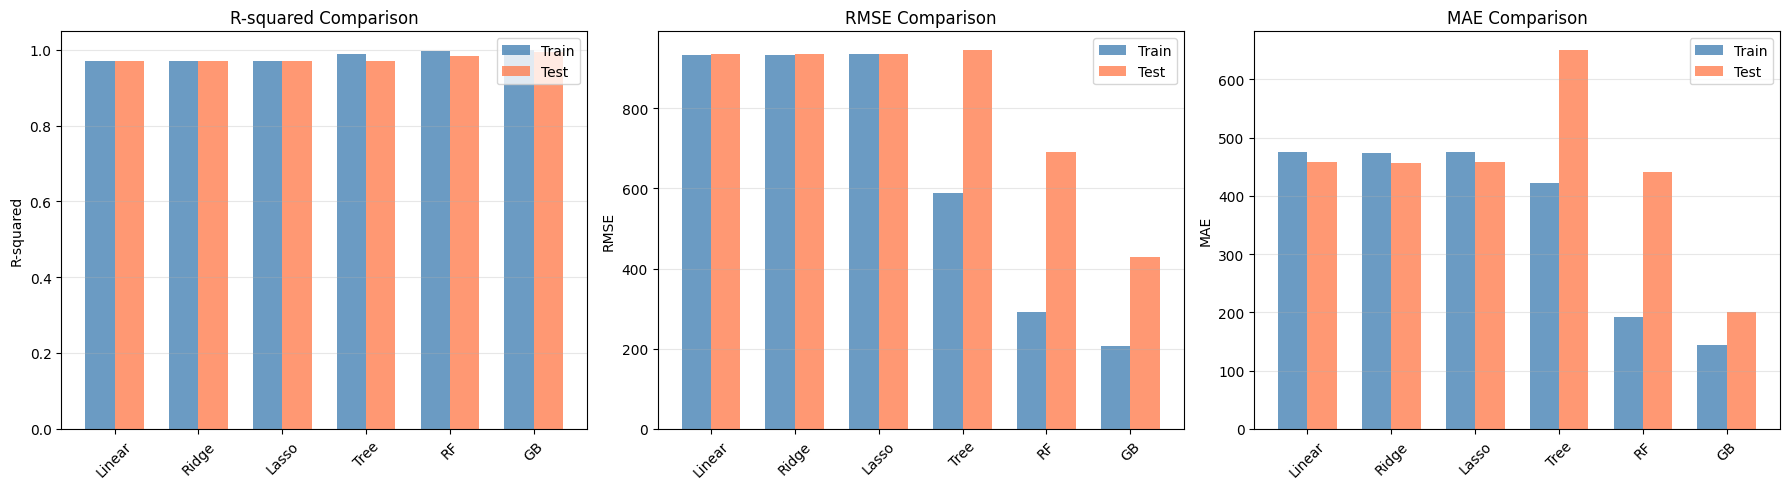

In [43]:
# Final visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Linear', 'Ridge', 'Lasso', 'Tree', 'RF', 'GB']
x = np.arange(len(models))
width = 0.35

# R2
axes[0].bar(x - width/2, final_comparison['Train_R2'], width, label='Train', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, final_comparison['Test_R2'], width, label='Test', color='coral', alpha=0.8)
axes[0].set_ylabel('R-squared')
axes[0].set_title('R-squared Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE
axes[1].bar(x - width/2, final_comparison['Train_RMSE'], width, label='Train', color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, final_comparison['Test_RMSE'], width, label='Test', color='coral', alpha=0.8)
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# MAE
axes[2].bar(x - width/2, final_comparison['Train_MAE'], width, label='Train', color='steelblue', alpha=0.8)
axes[2].bar(x + width/2, final_comparison['Test_MAE'], width, label='Test', color='coral', alpha=0.8)
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=45)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
# Best model selection and final analysis
best_final_idx = final_comparison['Test_R2'].idxmax()
best_final_model = final_comparison.loc[best_final_idx]

print("\n" + "="*90)
print("FINAL CONCLUSION")
print("="*90)
print(f"\nBest Overall Model: {best_final_model['Model']}")
print(f"\nPerformance Metrics:")
print(f"  Test R-squared: {best_final_model['Test_R2']:.4f}")
print(f"  Test RMSE: ${best_final_model['Test_RMSE']:.2f}")
print(f"  Test MAE: ${best_final_model['Test_MAE']:.2f}")

# Overfitting analysis
print("\n" + "-"*60)
print("Overfitting Analysis for All Models:")
print("-"*60)
for idx, row in final_comparison.iterrows():
    gap = row['Train_R2'] - row['Test_R2']
    status = "OVERFITTING" if gap > 0.15 else "SLIGHT OVERFITTING" if gap > 0.05 else "OK"
    print(f"{row['Model']:40} Gap: {gap:7.4f}  [{status}]")

print("\n" + "="*90)
print("RECOMMENDATIONS")
print("="*90)
print("""
1. Ensemble methods (Random Forest, Gradient Boosting) typically outperform 
   single models by combining multiple weak learners.

2. For this CLV prediction task:
   - If interpretability is crucial: Use Ridge/Lasso regression
   - If prediction accuracy is paramount: Use ensemble methods
   - If computation resources are limited: Use Decision Tree with proper pruning

3. Key factors for CLV prediction identified by feature importance analysis
   can inform business strategies for customer retention and value optimization.
""")


FINAL CONCLUSION

Best Overall Model: Gradient Boosting (Optimized)

Performance Metrics:
  Test R-squared: 0.9936
  Test RMSE: $428.99
  Test MAE: $200.24

------------------------------------------------------------
Overfitting Analysis for All Models:
------------------------------------------------------------
Multiple Linear Regression               Gap:  0.0010  [OK]
Ridge Regression (alpha=10)              Gap:  0.0010  [OK]
Lasso Regression (alpha=10)              Gap:  0.0010  [OK]
Decision Tree Regressor (Optimized)      Gap:  0.0193  [OK]
Random Forest (Optimized)                Gap:  0.0136  [OK]
Gradient Boosting (Optimized)            Gap:  0.0050  [OK]

RECOMMENDATIONS

1. Ensemble methods (Random Forest, Gradient Boosting) typically outperform 
   single models by combining multiple weak learners.

2. For this CLV prediction task:
   - If interpretability is crucial: Use Ridge/Lasso regression
   - If prediction accuracy is paramount: Use ensemble methods
   - If compu

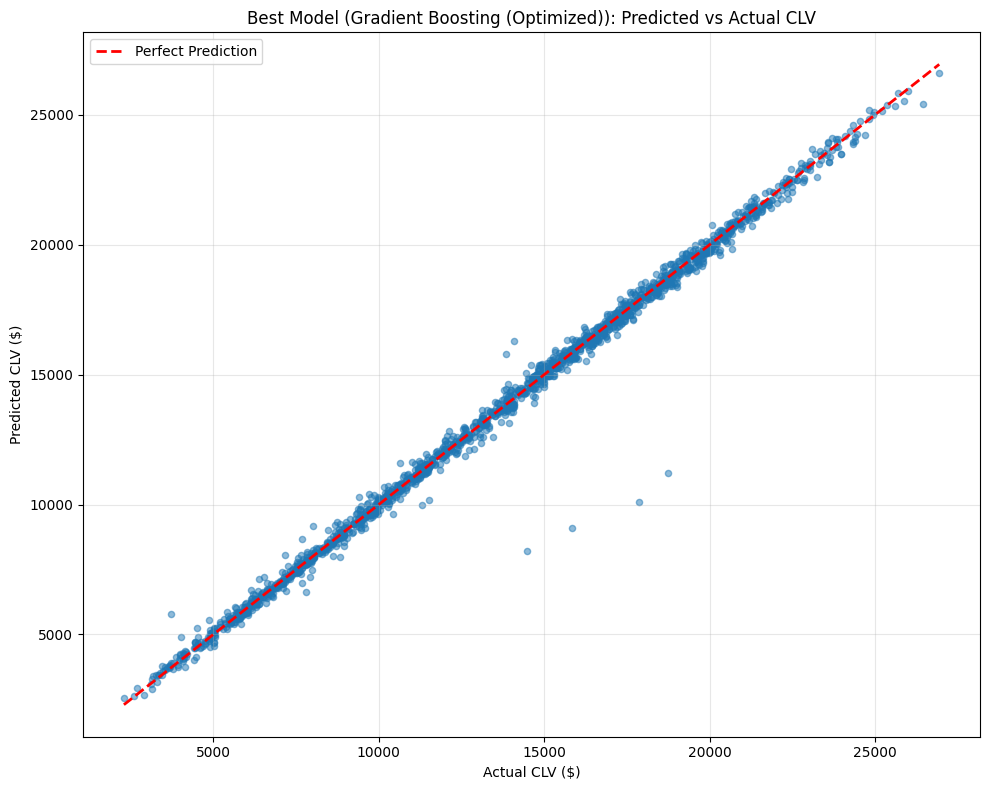

In [45]:
# Predicted vs Actual for best model
# Determine which predictions to use based on best model
best_predictions = {
    'Multiple Linear Regression': lr_pred,
    'Ridge Regression': ridge_pred,
    'Lasso Regression': lasso_pred,
    'Decision Tree Regressor (Optimized)': tree_pred,
    'Random Forest (Optimized)': rf_pred,
    'Gradient Boosting (Optimized)': gb_pred
}

# Find the key that matches best_final_model['Model']
best_model_key = None
for key in best_predictions.keys():
    if best_final_model['Model'] in key or key in best_final_model['Model']:
        best_model_key = key
        break

if best_model_key is None:
    # Default to gradient boosting if not found
    best_model_key = 'Gradient Boosting (Optimized)'

final_pred = best_predictions.get(best_model_key, gb_pred)

plt.figure(figsize=(10, 8))
plt.scatter(y_test, final_pred, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual CLV ($)')
plt.ylabel('Predicted CLV ($)')
plt.title(f'Best Model ({best_final_model["Model"]}): Predicted vs Actual CLV')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

This notebook completed all regression tasks for predicting Customer Lifetime Value:

1. **Task 1 - Data Preprocessing**: Cleaned data, handled missing values, fixed logical inconsistencies, encoded categorical variables, and scaled features.

2. **Task 2 - Multiple Linear Regression**: Built baseline model with interpretable coefficients.

3. **Task 3 - Polynomial Regression**: Explored degree 2 and 3 polynomials to capture non-linear relationships.

4. **Task 4 - Model Comparison**: Compared linear and polynomial models, identified risk of overfitting with higher degrees.

5. **Task 5 - Regularization**: Applied Ridge and Lasso regression with cross-validation and hyperparameter tuning.

6. **Task 6 - Regression Tree**: Trained optimized decision tree with hyperparameter tuning.

7. **Task 7 - Model Comparison**: Compared regularized models with decision tree, analyzed strengths and weaknesses.

8. **Task 8 - Ensemble Learning**: Applied Random Forest and Gradient Boosting, achieving the best predictive performance.

The ensemble methods demonstrated superior performance by combining multiple models to reduce variance and capture complex patterns in the data.